* DTD is a texture database, consisting of 5640 images, organized according to a list of 47 terms (categories) inspired from human perception. There are 120 images for each category. Image sizes range between 300x300 and 640x640, and the images contain at least 90% of the surface representing the category attribute. The images were collected from Google and Flickr by entering our proposed attributes and related terms as search queries. The images were annotated using Amazon Mechanical Turk in several iterations. For each image we provide key attribute (main category) and a list of joint attributes.

#### Step 1: Install Required Libraries

In [7]:
pip install opencv-python numpy matplotlib tensorflow keras


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Step 2: Load Images and Create Masks

In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Set paths for images and masks

image_dir = r'C:\Users\Siddhi\Desktop\SIDDHI_RAHUL_PAWAR_FDS\dtd\images\banded'
mask_dir = r'C:\Users\Siddhi\Desktop\AAI\dtd\MASK' 
# Directory to save masks
os.makedirs(mask_dir, exist_ok=True)

# Function to create masks
def create_mask(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a binary mask using thresholding
    _, binary_mask = cv2.threshold(gray_image, 120, 255, cv2.THRESH_BINARY)
    return binary_mask

# Load images and create masks
image_names = os.listdir(image_dir)

# Processing each image
for image_name in image_names:
    image_path = os.path.join(image_dir, image_name)
    
    mask = create_mask(image_path)
    
    # Save the mask
    mask_name = image_name.split('.')[0] + '_mask.png'
    mask_path = os.path.join(mask_dir, mask_name)
    cv2.imwrite(mask_path, mask)

print("Masks created and saved successfully.")


Masks created and saved successfully.


#### Step 3: Load Images and Masks for Training

In [8]:
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []

    # Load images and masks
    for image_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, image_name)
        mask_path = os.path.join(mask_dir, image_name.split('.')[0] + '_mask.png')

        if os.path.exists(mask_path):  # Ensure the mask exists
            
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size)
            image = image / 255.0  # Normalize image

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize mask
            masks.append(mask[..., np.newaxis])  # Add channel dimension example -(128, 128) to (128, 128, 1)

            images.append(image)# Appending the image to the images list

    return np.array(images), np.array(masks)

# Load the data
images, masks = load_data(image_dir, mask_dir)

print(f"Loaded {len(images)} images and {len(masks)} masks.")


Loaded 120 images and 120 masks.


#### Step 4: Define the U-Net Model

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

def unet_model(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Downsampling path
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Upsampling path
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 32)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 64)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 16, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 16, 16, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 16, 256)       │         590,080 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 8, 8, 256)         │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 8, 8, 512)         │       1,180,160 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 8, 8, 512)         │       2,359,808 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 16, 16, 256)       │         524,54

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 5: Train the U-Net Model

In [5]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=10,  # Adjust epochs as needed
                    batch_size=16, 
                    validation_data=(X_val, y_val))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.4365 - loss: 0.7050 - val_accuracy: 0.6285 - val_loss: 0.6055
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.6075 - loss: 0.6208 - val_accuracy: 0.6723 - val_loss: 0.5425
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.6637 - loss: 0.5442 - val_accuracy: 0.7718 - val_loss: 0.3957
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.7165 - loss: 0.4586 - val_accuracy: 0.6949 - val_loss: 0.5119
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.6514 - loss: 0.5408 - val_accuracy: 0.8829 - val_loss: 0.3200
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.8693 - loss: 0.3314 - val_accuracy: 0.8668 - val_loss: 0.2844
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.8799 - loss: 0.2636 - val_accuracy: 0.8878 - val_loss: 0.2126
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9002 - loss: 0.1984 - val_accuracy: 0.8964 - val_loss: 0.1832
Epoch 9/

#### Step 6: Visualize the Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


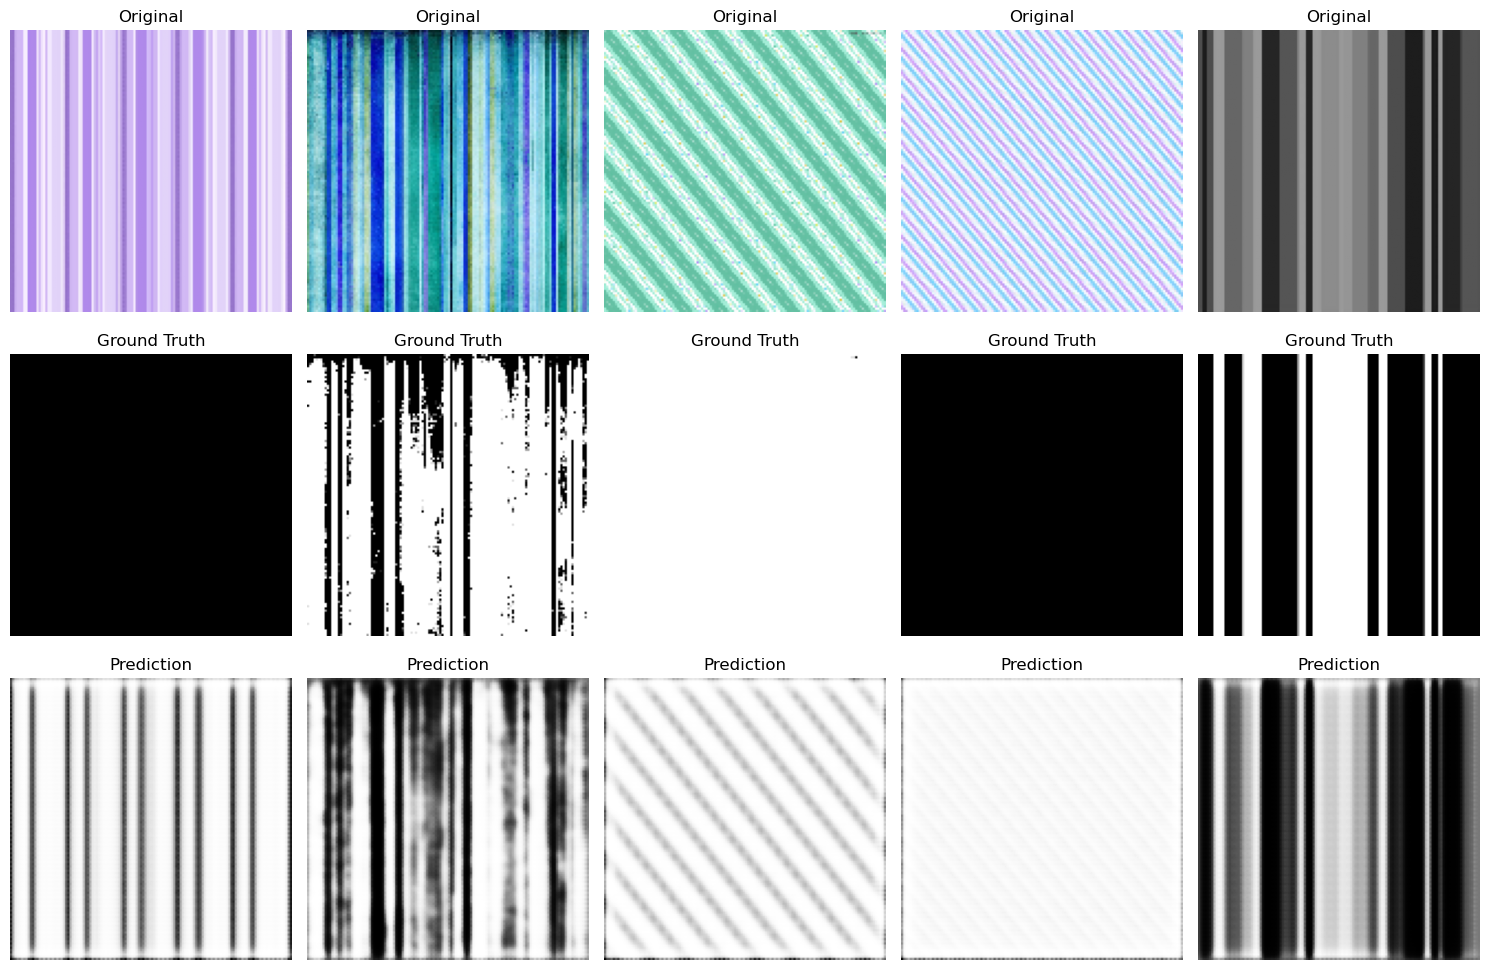

In [6]:
def visualize_results(model, X_val, y_val):
    preds = model.predict(X_val)

    plt.figure(figsize=(15, 10))
    
    for i in range(5):  # Display 5 examples
        plt.subplot(3, 5, i + 1)
        plt.imshow(X_val[i])
        plt.axis('off')
        plt.title("Original")
        
        plt.subplot(3, 5, i + 6)
        plt.imshow(y_val[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Ground Truth")

        plt.subplot(3, 5, i + 11)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Prediction")

    plt.tight_layout()
    plt.show()

# Visualize results on validation set
visualize_results(model, X_val, y_val)


* Mask Creation: Load images and create binary masks using OpenCV.
* Data Loading: Load images and masks into arrays.
* U-Net Model Definition: Define the U-Net architecture.
* Model Training: Train the U-Net model on the dataset.
* Visualization: Visualize the results to compare original images, ground truth masks, and model predictions.